# Horse Colic experiments
Code for experiments on the Horse Colic dataset.

Data can be downloaded at https://archive.ics.uci.edu/ml/datasets/Horse+Colic

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Preprocess data

In [3]:
def import_dataset(filename):
    names = ['X_%d' % (i) for i in range(28)]
    names[0] = 'T'
    names[2] = 'horse_id'
    names[22] = 'Y'
    names[23] = 'surgical_lesion'
    names[24] = 'lesion_type_1'
    names[25] = 'lesion_type_2'
    names[26] = 'lesion_type_3'
    
    df = pd.read_csv(filename, sep=' ', names=names, index_col=False, na_values='?')
    # Remove unused columns 26 and onward
    df = df[names[0:2] + names[3:23]]
    # Remap the treatments to 0,1
    df['T'] = -df['T'] + 2
    # Remove euthanized horses
    df = df[df['Y'] < 3]
    # Remap the outcomes to either lived or died
    df.Y = df.Y.replace({1: 1, 2: -1, 3: -1})
    
    x_columns_cat = ['X_1','X_6','X_7','X_8','X_9','X_10','X_11','X_12','X_13','X_14','X_16','X_17','X_20']
    # Replace categorial nans with "normal" category
    df[x_columns_cat] = df[x_columns_cat].fillna(1)
    # one-hot encode categorical features
    df = pd.get_dummies(df, columns=x_columns_cat, dummy_na=False)
    
    # Replace numerical nans with 0 value
    df = df.fillna(0)
    return df

In [4]:
# Import data
df = import_dataset("data/horsecolic/horse-colic.data")

# Fit model

We assume the outcome model is logistic with interaction terms,

$$P(Y=1 | T = t, X = x) = \frac{e^{\beta_0 + \beta_1 t + \beta_2 ^T x + \beta_3 ^T xt}}{1 + e^{\beta_0 + \beta_1 t + \beta_2^T x + \beta_3 ^T xt}},$$


In [5]:
class OutcomeModel:
    """Fits an outcome model."""
    
    def __init__(self, t_column, x_columns, y_column):
        self.t_column = t_column
        self.x_columns = x_columns
        self.y_column = y_column
    
    def fit_outcome(self, df_input):
        """Fits outcome model P(Y = 1 | X = x, T = t) using df_input."""
        raise("Not Implemented")
    
    def predict_Ys(self, df_input):
        """Returns a numpy array of predictions for each row in df_input."""
        raise("Not Implemented")
        

class OutcomeModelLogistic(OutcomeModel):
    """Fits a logistic model with interaction terms."""
    
    def __init__(self, t_column, x_columns, y_column):
        super().__init__(t_column, x_columns, y_column)
    
    def get_input_columns(self, df_input, deep_copy=False):
        inputs = df_input[[self.t_column] + self.x_columns].copy(deep=deep_copy)
        for x_column in self.x_columns:
            inputs[x_column + '*T'] = inputs[x_column] * inputs[self.t_column]
        return inputs
    
    def get_target_column(self, df_input):
        # Transforms y column values from -1,1 to 0,1. 
        return ((df_input[self.y_column] + 1)/2).astype(int)
    
    def fit_outcome(self, df_input, update_internal=True, print_results=False):
        """Fits logistic regression model on Y given X, T.
        
        If update_internal is True, updates internal outcome model.
        
        """
        inputs = self.get_input_columns(df_input)
        target = self.get_target_column(df_input)
        clf_outcome = LogisticRegression(random_state=0, solver='lbfgs', max_iter=30000, penalty='none').fit(inputs, target)        
        if update_internal:
            self.clf_outcome = clf_outcome
        if print_results:
            y_true = target
            print("Accuracy for outcome model: %f" % clf_outcome.score(inputs, df_input[self.y_column]))
            y_pred_probs = self.predict_Ys(df_input, probs=True)
            AUC = sklearn.metrics.roc_auc_score(y_true=y_true, y_score=y_pred_probs)
            print("AUC for outcome model: %f" % AUC)
            print('Coefficients for outcome model:', clf_outcome.coef_)
        return clf_outcome
    
    def print_metrics(self, df_input):
        y_true = self.get_target_column(df_input)
        inputs = self.get_input_columns(df_input)
        print("Accuracy for outcome model: %f" % self.clf_outcome.score(inputs, df_input[self.y_column]))
        y_pred_probs = self.predict_Ys(df_input, probs=True)
        AUC = sklearn.metrics.roc_auc_score(y_true=y_true, y_score=y_pred_probs)
        print("AUC for outcome model: %f" % AUC)
        
    def predict_Ys(self, df_input, probs=False):
        """Predicts outcome Y for given df_input.
        
        If probs is False, returns binary predictions for Y.
        If probs is True, returns probabilities.
        
        """
        inputs = self.get_input_columns(df_input)
        Y_probs = self.clf_outcome.predict_proba(inputs).T[1]
        if probs:
            return Y_probs
        else:
            Y = np.random.binomial(1, p=Y_probs)
            # Transform y column values from 0,1 to -1,1.
            Y = (Y * 2) - 1
            return Y 
        
    def predict_mu_0s(self, df_input):
        """Returns a numpy array of mu_0(x) values for each row in df_input.
        """
        df_input_cf = df_input.copy()
        df_input_cf['T'] = 0
        inputs = self.get_input_columns(df_input_cf)
        Y_probs = self.clf_outcome.predict_proba(inputs).T[1]
        return (Y_probs*2.) - 1.
    
    def predict_mu_0s_marginal(self, df_input, df_train, x_obs):
        """Returns a numpy array of mu_0(x) values for each row in df_input.
        
        if cols_to_use is None, then uses all columns. Otherwise, outputs average mu_0s over cols_to_use.
        For each row i in df_input, outputs
            E[E[Y(0) | x_obs, x_columns - x_obs] | x_obs = x_obs_i] = E_{df_train}[mu_0 | x_obs = x_obs_i].
        For each input row an average is taken over the training dataset, df_train.
        """ 
        results = []
        # If x_obs is none or empty
        if not x_obs:
            # Get average value for the row over df_train.
            df_filtered = df_train
            # Evaluate mu_0
            mu_0s_filtered = self.predict_mu_0s(df_filtered)
            mu_0_marg = mu_0s_filtered.mean()
            results = [mu_0_marg] * len(df_input)
        else:
            mu_0s_predicted = self.predict_mu_0s(df_train)
            df_train['mu_0'] = mu_0s_predicted
            grouped = df_train.groupby(x_obs).mean()
            print(grouped['mu_0'])
            mu_0_map = grouped['mu_0']
            # Apply grouped results to input df
            for _, row in df_input.iterrows():
                # Get correct row
                if len(x_obs) > 1:
                    mu_0_result = mu_0_map[tuple(row[x_obs].values)]
                else:
                    mu_0_result = mu_0_map[row[x_obs].values[0]]
                results.append(mu_0_result)
        return np.array(results)
    
    def predict_mu_1s(self, df_input):
        """Returns a numpy array of mu_1(x) values for each row in df_input."""
        df_input_cf = df_input.copy()
        df_input_cf['T'] = 1
        inputs = self.get_input_columns(df_input_cf)
        Y_probs = self.clf_outcome.predict_proba(inputs).T[1]
        return (Y_probs*2.) - 1.


In [7]:
t_column = 'T'
y_column = 'Y'
x_columns = list(df.columns)
x_columns.remove(t_column)
x_columns.remove(y_column)

In [8]:
outcome_model = OutcomeModelLogistic(t_column, x_columns, y_column)

In [9]:
outcome_model.fit_outcome(df, print_results=True)

Accuracy for outcome model: 0.682353
AUC for outcome model: 0.992485
Coefficients for outcome model: [[  0.34640061  -0.38691621  -0.13014401   0.66090419  -4.14334363
   -1.6489582   12.19911943   4.35017684   4.52067154  -1.18712894
    4.36905473   4.39791918  -8.01377835   2.58034705   3.25929144
    0.28343924  -2.36714444   2.15795637  -0.55273024  -0.4678927
    1.52506972   6.05629233  -6.13723905   2.91004254   4.92082207
   -1.19651455  -0.39076492   3.82733588   9.78143355  -1.51822361
   -5.16213327  -3.59486994  -3.01370189   6.4416496    0.340065
   -0.43447009   9.80378481   2.76917029  -5.74747821  -3.49193427
   -4.48234564   5.2737192    2.54216906  -0.43116532   0.53254983
    3.2321581   -0.01622795   4.70181076  -2.12307234   0.77103214
   -1.43652309   5.45430388   6.81250151   2.31114732  -9.80788702
   -6.02411651   5.30208747   4.05557165   0.51425113   0.04587948
   -0.57783461   4.2383122    1.49043746 -11.41143011  -4.76200247
   -1.31529781   1.66169842  -4

LogisticRegression(max_iter=30000, penalty='none', random_state=0)

# Calculate regrets

In [11]:
mu_0s = outcome_model.predict_mu_0s(df)

In [13]:
mu_1s = outcome_model.predict_mu_1s(df)

In [14]:
print("Number of units where treatment would be good: %d" % (mu_1s - mu_0s > 0).sum())

Number of units where treatment would be good: 62


In [15]:
print("Number of units where treatment would be bad: %d" % (mu_1s - mu_0s < 0).sum())

Number of units where treatment would be bad: 146


In [16]:
T_OPT = (mu_1s > mu_0s).astype(int)
V_OPT = ((mu_1s - mu_0s)* T_OPT).mean()
print("Optimal utility: %f" % V_OPT)
print("Optimal probability of treatment: %f" % T_OPT.mean())

Optimal utility: 0.147742
Optimal probability of treatment: 0.243137


In [17]:
# ATO reward:
T_ATO = (mu_1s == mu_1s.max()).astype(int)
V_ATO = ((mu_1s - mu_0s) * T_ATO).mean()
R_ATO = V_OPT - V_ATO
print("ATO utility: %f, ATO regret: %f" % (V_ATO, R_ATO))
print("ATO probability of treatment: %f" % T_ATO.mean())

ATO utility: 0.000000, ATO regret: 0.147742
ATO probability of treatment: 0.192157


In [18]:
# Total treated outcome reward: 
T_TO = (mu_1s > 0).astype(int)
V_TO = ((mu_1s - mu_0s) * T_TO).mean()
R_TO = V_OPT - V_TO
print("TO utility: %f, TO regret: %f" % (V_TO, R_TO))
print("TO probability of treatment: %f" % T_TO.mean())

TO utility: 0.085685, TO regret: 0.062057
TO probability of treatment: 0.670588


In [19]:
# ATT reward:
T_ATT = (mu_1s - mu_0s == (mu_1s - mu_0s).max()).astype(int)
V_ATT = ((mu_1s - mu_0s) * T_ATT).mean()
R_ATT = V_OPT - V_ATT
print("ATT utility: %f, ATT regret: %f" % (V_ATT, R_ATT))
print("ATT probability of treatment: %f" % T_ATT.mean())

ATT utility: 0.007843, ATT regret: 0.139899
ATT probability of treatment: 0.003922


# Information asymmetry

## Demographic information
Suppose the principal identifies $E[Y(0) | X]$ where $X$ includes age only.

In [21]:
mu_0s_marginal = outcome_model.predict_mu_0s_marginal(df, df, ['X_1_1','X_1_9'])
# TT reward
T_TT = (mu_1s - mu_0s_marginal > 0).astype(int)
V_TT = ((mu_1s - mu_0s) * T_TT).mean()
R_TT = V_OPT - V_TT
print("actual utility: %f, actual regret: %f, regret as percent value lost: %.2f, " % (V_TT, R_TT, R_TT/V_OPT * 100))
print("probability of treatment: %f" % T_TT.mean())

X_1_1  X_1_9
0      1        0.506823
1      0        0.551902
Name: mu_0, dtype: float64
actual utility: 0.100081, actual regret: 0.047661, regret as percent value lost: 32.26, 
probability of treatment: 0.623529


 ## No information
 Suppose the principal gets no features and just identifies $E[Y(0)]$.

In [22]:
mu_0s_marginal = outcome_model.predict_mu_0s_marginal(df, df, [])
T_TT = (mu_1s - mu_0s_marginal > 0).astype(int)
V_TT = ((mu_1s - mu_0s) * T_TT).mean()
R_TT = V_OPT - V_TT
print("no info utility: %f, no info regret: %f" % (V_TT, R_TT))
print("no info probability of treatment: %f" % T_TT.mean())

no info utility: 0.100081, no info regret: 0.047661
no info probability of treatment: 0.623529


## Individual features

In [23]:
feature_groups = {'Rectal temperature': ['X_3'],
                  'Pulse': ['X_4'], 
                  'Respiratory rate': ['X_5'], 
                  'Nasogastric reflux PH': ['X_15'], 
                  'Packed cell volume': ['X_18'], 
                  'Total protein': ['X_19'],
                  'Abdomcentesis total protein': ['X_21'],
                  'Age': ['X_1_1', 'X_1_9'], 
                  'Temperature of extremities': ['X_6_1.0', 'X_6_2.0', 'X_6_3.0', 'X_6_4.0'], 
                  'Peripheral pulse': ['X_7_1.0','X_7_2.0', 'X_7_3.0', 'X_7_4.0'], 
                  'Mucous membranes': ['X_8_1.0', 'X_8_2.0', 'X_8_3.0', 'X_8_4.0', 'X_8_5.0', 'X_8_6.0'], 
                  'Capillary refill time': ['X_9_1.0', 'X_9_2.0', 'X_9_3.0'],
                  'Pain': ['X_10_1.0', 'X_10_2.0', 'X_10_3.0', 'X_10_4.0', 'X_10_5.0'], 
                  'Peristalsis': ['X_11_1.0','X_11_2.0', 'X_11_3.0', 'X_11_4.0'], 
                  'Abdominal distension': ['X_12_1.0', 'X_12_2.0', 'X_12_3.0', 'X_12_4.0'], 
                  'Nasogastric tube': ['X_13_1.0', 'X_13_2.0', 'X_13_3.0'], 
                  'Nasogastric reflux': ['X_14_1.0', 'X_14_2.0','X_14_3.0'], 
                  'Rectal examination - feces': ['X_16_1.0', 'X_16_2.0', 'X_16_3.0', 'X_16_4.0'], 
                  'Abdomen': ['X_17_1.0','X_17_2.0', 'X_17_3.0', 'X_17_4.0', 'X_17_5.0'], 
                  'Abdominocentesis appearance': ['X_20_1.0', 'X_20_2.0','X_20_3.0']}


In [95]:
# Calculate gamma_margs for each individual feature
gamma_margs = {}
for name, feature_group in feature_groups.items():
    mu_0s_marginal = outcome_model.predict_mu_0s_marginal(df, df, feature_group)
    gamma_marg = (np.abs(mu_0s_marginal - mu_0s)).mean()
    gamma_margs[name] = gamma_marg

X_3
0.0     0.422570
36.0   -0.999872
36.4    1.000000
36.5    0.623532
36.6   -0.999993
36.8    1.000000
36.9    0.999988
37.0    0.999969
37.1    1.000000
37.2    0.000026
37.3    0.200000
37.4    0.997260
37.5    0.600000
37.6    0.281082
37.7    0.149127
37.8    0.999611
37.9    0.453668
38.0    0.480660
38.1    0.441999
38.2    0.999981
38.3    0.887266
38.4    0.636363
38.5    0.488020
38.6    0.833309
38.7    0.649027
38.8    0.335443
38.9   -0.500000
39.0    0.499998
39.1    1.000000
39.2    0.828005
39.3    0.333333
39.4    0.999982
39.5    0.333333
39.6    0.999423
39.9    1.000000
40.0   -1.000000
40.3   -0.999989
40.8    1.000000
Name: mu_0, dtype: float64
X_4
0.0      3.913055e-01
30.0     9.994354e-01
36.0     1.000000e+00
38.0     1.000000e+00
40.0     8.666626e-01
42.0     6.000042e-01
44.0     8.182444e-01
45.0     1.000000e+00
46.0     1.000000e+00
48.0     9.208676e-01
49.0     1.000000e+00
50.0     9.999943e-01
52.0     9.996525e-01
54.0     9.999363e-01
56.0     6.

In [107]:
# Calculate gamma_marg for no features
mu_0s_marginal = outcome_model.predict_mu_0s_marginal(df, df, [])
none_gamma_marg = (np.abs(mu_0s_marginal - mu_0s)).mean()
print(none_gamma_marg)

0.6853127566846564


In [96]:
gamma_margs

{'Rectal temperature': 0.5644212613850274,
 'Pulse': 0.43162809716699485,
 'Respiratory rate': 0.5908440409830318,
 'Nasogastric reflux PH': 0.605298261032019,
 'Packed cell volume': 0.38928607990441816,
 'Total protein': 0.4736558304677289,
 'Abdomcentesis total protein': 0.6012005162663123,
 'Age': 0.6851047793160424,
 'Temperature of extremities': 0.5910352925846828,
 'Peripheral pulse': 0.5487480891360209,
 'Mucous membranes': 0.5517726828313303,
 'Capillary refill time': 0.5645487086086102,
 'Pain': 0.5785494254361817,
 'Peristalsis': 0.643219987270268,
 'Abdominal distension': 0.5716984264805729,
 'Nasogastric tube': 0.6641322047817367,
 'Nasogastric reflux': 0.6396445516246833,
 'Rectal examination - feces': 0.6418991064115169,
 'Abdomen': 0.6278204995659196,
 'Abdominocentesis appearance': 0.6658644823837477}

In [97]:
sorted_gamma_margs = dict(sorted(gamma_margs.items(), key=lambda item: item[1]))

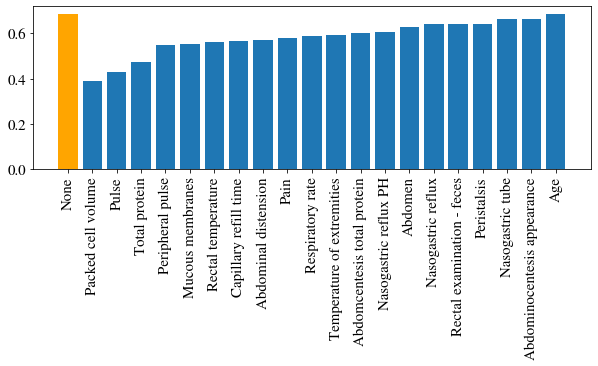

In [109]:
plt.figure(figsize = (10, 3))
plt.bar('None', none_gamma_marg, color='orange')
plt.bar(sorted_gamma_margs.keys(), sorted_gamma_margs.values())
plt.xticks(rotation=90)
plt.tick_params(labelsize = 15)
plt.savefig('plots/hc_gammas.pdf', format='pdf', bbox_inches = "tight")
plt.show()

In [99]:
# Regret for individual features
regrets_individual = {}
for name in sorted_gamma_margs.keys():
    feature_group = feature_groups[name]
    mu_0s_marginal = outcome_model.predict_mu_0s_marginal(df, df, feature_group)
    T_TT = (mu_1s - mu_0s_marginal > 0).astype(int)
    V_TT = ((mu_1s - mu_0s) * T_TT).mean()
    R_TT = V_OPT - V_TT
    regrets_individual[name] = R_TT
regrets_individual

X_18
0.0     0.528171
23.0    1.000000
24.0    1.000000
26.0    1.000000
28.0    1.000000
30.0    1.000000
31.0    1.000000
31.5    1.000000
32.0    1.000000
33.0    0.332212
34.0    1.000000
35.0    0.999981
36.0    0.777778
37.0    0.854838
37.5    0.999988
38.0    0.499971
39.0    1.000000
40.0    0.999955
41.0    0.714286
42.0    0.999997
43.0    0.818186
44.0    0.694542
45.0    0.669371
46.0    0.500000
47.0    0.399967
48.0    0.999492
49.0    0.999994
50.0    0.780094
51.0    1.000000
52.0   -0.579388
53.0    1.000000
54.0   -0.000015
55.0    0.499987
56.0    1.000000
57.0   -0.450731
58.0    0.931959
59.0   -0.000288
60.0   -0.564449
63.0   -1.000000
64.0   -0.333291
65.0   -1.000000
66.0   -1.000000
68.0   -0.500000
69.0   -0.998814
70.0   -1.000000
71.0    1.000000
72.0   -1.000000
73.0   -1.000000
74.0   -1.000000
75.0   -1.000000
Name: mu_0, dtype: float64
X_4
0.0      3.913055e-01
30.0     9.994354e-01
36.0     1.000000e+00
38.0     1.000000e+00
40.0     8.666626e-01
42.0

{'Packed cell volume': 0.028764327796128322,
 'Pulse': 0.03759688532393096,
 'Total protein': 0.030290903590345156,
 'Peripheral pulse': 0.037924071334035636,
 'Mucous membranes': 0.048945447482877505,
 'Rectal temperature': 0.03895983388884568,
 'Capillary refill time': 0.04361184474013735,
 'Abdominal distension': 0.040408480361297516,
 'Pain': 0.0366477485636018,
 'Respiratory rate': 0.04393966056534723,
 'Temperature of extremities': 0.04640594486185516,
 'Abdomcentesis total protein': 0.05107143043265493,
 'Nasogastric reflux PH': 0.03439868879123037,
 'Abdomen': 0.03648096913889848,
 'Nasogastric reflux': 0.04620247520830792,
 'Rectal examination - feces': 0.046622597015231915,
 'Peristalsis': 0.03743364097426406,
 'Nasogastric tube': 0.04256571463908794,
 'Abdominocentesis appearance': 0.04073693946082424,
 'Age': 0.04766072691054084}

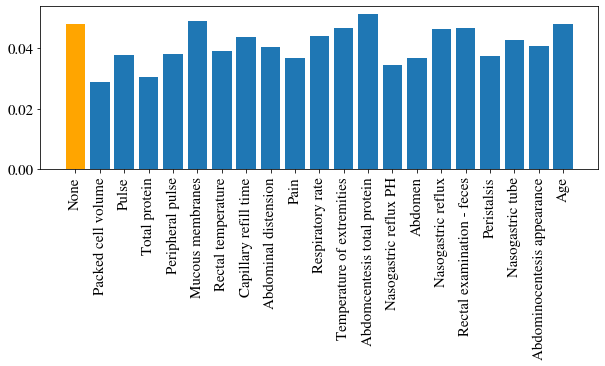

In [104]:
# Plot regrets with the same sorted order as the gamma_margs.
plt.figure(figsize = (10, 3))
plt.bar('None', regrets_cumulative['None'], color='orange')
plt.bar(regrets_individual.keys(), regrets_individual.values())
plt.xticks(rotation=90)
plt.tick_params(labelsize = 15)
plt.savefig('plots/hc_regrets_indiv.pdf', format='pdf', bbox_inches = "tight")
plt.show()

In [101]:
regrets_cumulative = {}
feature_group = []
mu_0s_marginal = outcome_model.predict_mu_0s_marginal(df, df, [])
T_TT = (mu_1s - mu_0s_marginal > 0).astype(int)
V_TT = ((mu_1s - mu_0s) * T_TT).mean()
R_TT = V_OPT - V_TT
regrets_cumulative['None'] = R_TT
for name in sorted_gamma_margs.keys():
    feature_group += feature_groups[name]
    print(feature_group)
    mu_0s_marginal = outcome_model.predict_mu_0s_marginal(df, df, feature_group)
    T_TT = (mu_1s - mu_0s_marginal > 0).astype(int)
    V_TT = ((mu_1s - mu_0s) * T_TT).mean()
    R_TT = V_OPT - V_TT
    regrets_cumulative[name] = R_TT
regrets_cumulative

['X_18']
X_18
0.0     0.528171
23.0    1.000000
24.0    1.000000
26.0    1.000000
28.0    1.000000
30.0    1.000000
31.0    1.000000
31.5    1.000000
32.0    1.000000
33.0    0.332212
34.0    1.000000
35.0    0.999981
36.0    0.777778
37.0    0.854838
37.5    0.999988
38.0    0.499971
39.0    1.000000
40.0    0.999955
41.0    0.714286
42.0    0.999997
43.0    0.818186
44.0    0.694542
45.0    0.669371
46.0    0.500000
47.0    0.399967
48.0    0.999492
49.0    0.999994
50.0    0.780094
51.0    1.000000
52.0   -0.579388
53.0    1.000000
54.0   -0.000015
55.0    0.499987
56.0    1.000000
57.0   -0.450731
58.0    0.931959
59.0   -0.000288
60.0   -0.564449
63.0   -1.000000
64.0   -0.333291
65.0   -1.000000
66.0   -1.000000
68.0   -0.500000
69.0   -0.998814
70.0   -1.000000
71.0    1.000000
72.0   -1.000000
73.0   -1.000000
74.0   -1.000000
75.0   -1.000000
Name: mu_0, dtype: float64
['X_18', 'X_4']
X_18  X_4  
0.0   0.0      0.666667
      30.0     0.998871
      42.0     0.999953
      44.

X_18  X_4    X_19  X_7_1.0  X_7_2.0  X_7_3.0  X_7_4.0  X_8_1.0  X_8_2.0  X_8_3.0  X_8_4.0  X_8_5.0  X_8_6.0  X_3   X_9_1.0  X_9_2.0  X_9_3.0  X_12_1.0  X_12_2.0  X_12_3.0  X_12_4.0  X_10_1.0  X_10_2.0  X_10_3.0  X_10_4.0  X_10_5.0
0.0   0.0    0.0   0        0        0        1        0        0        0        0        0        1        0.0   1        0        0        0         0         0         1         0         0         0         1         0          -0.999999
                   1        0        0        0        0        0        1        0        0        0        0.0   1        0        0        0         1         0         0         0         1         0         0         0           1.000000
                                                       1        0        0        0        0        0        0.0   1        0        0        1         0         0         0         1         0         0         0         0           1.000000
      30.0   0.0   1        0        0  

['X_18', 'X_4', 'X_19', 'X_7_1.0', 'X_7_2.0', 'X_7_3.0', 'X_7_4.0', 'X_8_1.0', 'X_8_2.0', 'X_8_3.0', 'X_8_4.0', 'X_8_5.0', 'X_8_6.0', 'X_3', 'X_9_1.0', 'X_9_2.0', 'X_9_3.0', 'X_12_1.0', 'X_12_2.0', 'X_12_3.0', 'X_12_4.0', 'X_10_1.0', 'X_10_2.0', 'X_10_3.0', 'X_10_4.0', 'X_10_5.0', 'X_5', 'X_6_1.0', 'X_6_2.0', 'X_6_3.0', 'X_6_4.0', 'X_21']
X_18  X_4    X_19  X_7_1.0  X_7_2.0  X_7_3.0  X_7_4.0  X_8_1.0  X_8_2.0  X_8_3.0  X_8_4.0  X_8_5.0  X_8_6.0  X_3   X_9_1.0  X_9_2.0  X_9_3.0  X_12_1.0  X_12_2.0  X_12_3.0  X_12_4.0  X_10_1.0  X_10_2.0  X_10_3.0  X_10_4.0  X_10_5.0  X_5   X_6_1.0  X_6_2.0  X_6_3.0  X_6_4.0  X_21
0.0   0.0    0.0   0        0        0        1        0        0        0        0        0        1        0.0   1        0        0        0         0         0         1         0         0         0         1         0         0.0   0        0        1        0        0.0    -0.999999
                   1        0        0        0        0        0        1        0      

X_18  X_4    X_19  X_7_1.0  X_7_2.0  X_7_3.0  X_7_4.0  X_8_1.0  X_8_2.0  X_8_3.0  X_8_4.0  X_8_5.0  X_8_6.0  X_3   X_9_1.0  X_9_2.0  X_9_3.0  X_12_1.0  X_12_2.0  X_12_3.0  X_12_4.0  X_10_1.0  X_10_2.0  X_10_3.0  X_10_4.0  X_10_5.0  X_5   X_6_1.0  X_6_2.0  X_6_3.0  X_6_4.0  X_21  X_15  X_17_1.0  X_17_2.0  X_17_3.0  X_17_4.0  X_17_5.0
0.0   0.0    0.0   0        0        0        1        0        0        0        0        0        1        0.0   1        0        0        0         0         0         1         0         0         0         1         0         0.0   0        0        1        0        0.0   0.0   1         0         0         0         0          -0.999999
                   1        0        0        0        0        0        1        0        0        0        0.0   1        0        0        0         1         0         0         0         1         0         0         0         0.0   0        1        0        0        0.0   0.0   0         0         1         0 

X_18  X_4    X_19  X_7_1.0  X_7_2.0  X_7_3.0  X_7_4.0  X_8_1.0  X_8_2.0  X_8_3.0  X_8_4.0  X_8_5.0  X_8_6.0  X_3   X_9_1.0  X_9_2.0  X_9_3.0  X_12_1.0  X_12_2.0  X_12_3.0  X_12_4.0  X_10_1.0  X_10_2.0  X_10_3.0  X_10_4.0  X_10_5.0  X_5   X_6_1.0  X_6_2.0  X_6_3.0  X_6_4.0  X_21  X_15  X_17_1.0  X_17_2.0  X_17_3.0  X_17_4.0  X_17_5.0  X_14_1.0  X_14_2.0  X_14_3.0  X_16_1.0  X_16_2.0  X_16_3.0  X_16_4.0
0.0   0.0    0.0   0        0        0        1        0        0        0        0        0        1        0.0   1        0        0        0         0         0         1         0         0         0         1         0         0.0   0        0        1        0        0.0   0.0   1         0         0         0         0         1         0         0         1         0         0         0          -0.999999
                   1        0        0        0        0        0        1        0        0        0        0.0   1        0        0        0         1         0         0     

X_18  X_4    X_19  X_7_1.0  X_7_2.0  X_7_3.0  X_7_4.0  X_8_1.0  X_8_2.0  X_8_3.0  X_8_4.0  X_8_5.0  X_8_6.0  X_3   X_9_1.0  X_9_2.0  X_9_3.0  X_12_1.0  X_12_2.0  X_12_3.0  X_12_4.0  X_10_1.0  X_10_2.0  X_10_3.0  X_10_4.0  X_10_5.0  X_5   X_6_1.0  X_6_2.0  X_6_3.0  X_6_4.0  X_21  X_15  X_17_1.0  X_17_2.0  X_17_3.0  X_17_4.0  X_17_5.0  X_14_1.0  X_14_2.0  X_14_3.0  X_16_1.0  X_16_2.0  X_16_3.0  X_16_4.0  X_11_1.0  X_11_2.0  X_11_3.0  X_11_4.0  X_13_1.0  X_13_2.0  X_13_3.0
0.0   0.0    0.0   0        0        0        1        0        0        0        0        0        1        0.0   1        0        0        0         0         0         1         0         0         0         1         0         0.0   0        0        1        0        0.0   0.0   1         0         0         0         0         1         0         0         1         0         0         0         1         0         0         0         1         0         0          -0.999999
                   1        0        0

X_18  X_4    X_19  X_7_1.0  X_7_2.0  X_7_3.0  X_7_4.0  X_8_1.0  X_8_2.0  X_8_3.0  X_8_4.0  X_8_5.0  X_8_6.0  X_3   X_9_1.0  X_9_2.0  X_9_3.0  X_12_1.0  X_12_2.0  X_12_3.0  X_12_4.0  X_10_1.0  X_10_2.0  X_10_3.0  X_10_4.0  X_10_5.0  X_5   X_6_1.0  X_6_2.0  X_6_3.0  X_6_4.0  X_21  X_15  X_17_1.0  X_17_2.0  X_17_3.0  X_17_4.0  X_17_5.0  X_14_1.0  X_14_2.0  X_14_3.0  X_16_1.0  X_16_2.0  X_16_3.0  X_16_4.0  X_11_1.0  X_11_2.0  X_11_3.0  X_11_4.0  X_13_1.0  X_13_2.0  X_13_3.0  X_20_1.0  X_20_2.0  X_20_3.0  X_1_1  X_1_9
0.0   0.0    0.0   0        0        0        1        0        0        0        0        0        1        0.0   1        0        0        0         0         0         1         0         0         0         1         0         0.0   0        0        1        0        0.0   0.0   1         0         0         0         0         1         0         0         1         0         0         0         1         0         0         0         1         0         0         1    

{'None': 0.04766072691054084,
 'Packed cell volume': 0.028764327796128322,
 'Pulse': 0.0007860262693329956,
 'Total protein': 0.0007860262533416207,
 'Peripheral pulse': 0.0007860262533416207,
 'Mucous membranes': 0.0007860262522953465,
 'Rectal temperature': 2.2896684548356916e-12,
 'Capillary refill time': 0.0,
 'Abdominal distension': 0.0,
 'Pain': 0.0,
 'Respiratory rate': 0.0,
 'Temperature of extremities': 0.0,
 'Abdomcentesis total protein': 0.0,
 'Nasogastric reflux PH': 0.0,
 'Abdomen': 0.0,
 'Nasogastric reflux': 0.0,
 'Rectal examination - feces': 0.0,
 'Peristalsis': 0.0,
 'Nasogastric tube': 0.0,
 'Abdominocentesis appearance': 0.0,
 'Age': 0.0}

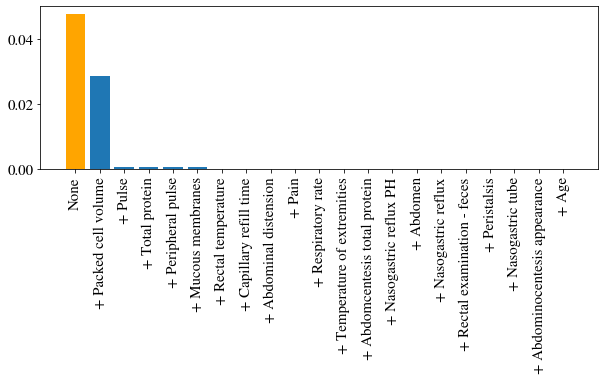

In [106]:
plt.figure(figsize = (10, 3))
xlabels = list(regrets_cumulative.keys())
for i in range(1,len(xlabels)):
    xlabels[i] = '+ ' + xlabels[i]
plt.bar(xlabels, regrets_cumulative.values())
plt.bar('None', regrets_cumulative['None'], color='orange')
plt.xticks(rotation=90)
plt.tick_params(labelsize = 15)
plt.savefig('plots/hc_regrets_cumul.pdf', format='pdf', bbox_inches = "tight")
plt.show()